In [8]:
import pandas as pd

# Load the dataset
df_sdi = pd.read_csv('EAPC_analysis/Incidence_ASR_REGIONAL_SDI.csv')

# Display the first few rows of the DataFrame
print("DataFrame head for Incidence_ASR_REGIONAL_SDI.csv:")
print(df_sdi.head())

# Display column names and their data types
print("\nDataFrame info for Incidence_ASR_REGIONAL_SDI.csv:")
print(df_sdi.info())

# Get unique values in 'location_name' to confirm SDI regions
print("\nUnique values in 'location_name' column:")
unique_locations = df_sdi['location_name'].unique()
print(unique_locations)

# Filter out 'Global' data, assuming other unique location_names represent SDI regions
# The SDI regions are usually "High SDI", "High-middle SDI", "Middle SDI", "Low-middle SDI", "Low SDI".
# Let's filter for those exact names if they exist, otherwise, filter out 'Global' and assume the rest are SDI regions.
sdi_regions_list = [
    'High SDI',
    'High-middle SDI',
    'Middle SDI',
    'Low-middle SDI',
    'Low SDI'
]

# Check if any of these exact SDI region names are present in unique_locations
found_sdi_regions = [loc for loc in unique_locations if loc in sdi_regions_list]

if found_sdi_regions:
    # If explicit SDI regions are found, filter by them
    filtered_sdi_df = df_sdi[df_sdi['location_name'].isin(sdi_regions_list)].copy()
    print("\nFiltering by explicit SDI region names.")
else:
    # If explicit SDI regions are not found, assume all non-Global locations are SDI regions
    filtered_sdi_df = df_sdi[df_sdi['location_name'] != 'Global'].copy()
    print("\nNo explicit SDI region names found. Filtering out 'Global' and assuming remaining locations are SDI regions.")

if filtered_sdi_df.empty:
    print("\nNo SDI region data found after filtering. The 'location_name' column may not contain expected SDI region identifiers.")
else:
    # Select relevant columns for the new file.
    # 'location_name' will now represent the SDI region.
    sdi_data_to_extract = filtered_sdi_df[['location_name', 'year', 'val', 'upper', 'lower']].copy()

    # Save the extracted data to a new CSV file
    output_filename = 'EAPC_analysis/Incidence_ASR_SDI.csv'
    sdi_data_to_extract.to_csv(output_filename, index=False)

    print(f"\nExtracted SDI region data saved to '{output_filename}'")

DataFrame head for Incidence_ASR_REGIONAL_SDI.csv:
   measure_id measure_name  location_id   location_name  sex_id sex_name  \
0           6    Incidence           42  Central Europe       3     Both   
1           6    Incidence           42  Central Europe       3     Both   
2           6    Incidence           42  Central Europe       3     Both   
3           6    Incidence           42  Central Europe       3     Both   
4           6    Incidence           42  Central Europe       3     Both   

   age_id          age_name  cause_id     cause_name  metric_id metric_name  \
0      27  Age-standardized       559  Schizophrenia          3        Rate   
1      27  Age-standardized       559  Schizophrenia          3        Rate   
2      27  Age-standardized       559  Schizophrenia          3        Rate   
3      27  Age-standardized       559  Schizophrenia          3        Rate   
4      27  Age-standardized       559  Schizophrenia          3        Rate   

   year        va

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load your CSV file
df = pd.read_csv("analysis_data/Prevalence_ASR_GENDERED.csv")

# Filter only age-standardized data
df = df[df['age_name'] == 'Age-standardized']

# Define EAPC calculation function
def calc_eapc(df, rate_col='val', year_col='year'):
    df = df.dropna(subset=[year_col, rate_col])
    df['log_rate'] = np.log(df[rate_col])
    X = sm.add_constant(df[year_col])
    model = sm.OLS(df['log_rate'], X).fit()

    beta = model.params[year_col]
    ci_low_b, ci_up_b = model.conf_int().loc[year_col]

    eapc = 100 * (np.exp(beta) - 1)
    ci_low = 100 * (np.exp(ci_low_b) - 1)
    ci_up = 100 * (np.exp(ci_up_b) - 1)

    return {
        'EAPC': eapc,
        'CI_lower': ci_low,
        'CI_upper': ci_up,
        'p_value': model.pvalues[year_col],
        'r_squared': model.rsquared
    }

# Group by sex and apply EAPC calculation
results = {}
for sex, group in df.groupby('sex_name'):
    results[sex] = calc_eapc(group)

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
results_df.index.name = 'Sex'
print(results_df)


            EAPC  CI_lower  CI_upper       p_value  r_squared
Sex                                                          
Both    0.029182  0.018827  0.039539  2.764320e-06   0.524783
Female  0.023281  0.012422  0.034142  1.335990e-04   0.389924
Male    0.037664  0.026631  0.048698  9.554091e-08   0.618402


In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load your CSV file
df = pd.read_csv("EAPC_analysis/Incidence_ASR_REGIONAL_SDI.csv")

# Filter only age-standardized data
df = df[df['age_name'] == 'Age-standardized']

# Define EAPC calculation function
def calc_eapc(df, rate_col='val', year_col='year'):
    df = df.dropna(subset=[year_col, rate_col])
    df['log_rate'] = np.log(df[rate_col])
    X = sm.add_constant(df[year_col])
    model = sm.OLS(df['log_rate'], X).fit()

    beta = model.params[year_col]
    ci_low_b, ci_up_b = model.conf_int().loc[year_col]

    eapc = round(100 * (np.exp(beta) - 1), 3)
    ci_low = round(100 * (np.exp(ci_low_b) - 1), 3)
    ci_up = round(100 * (np.exp(ci_up_b) - 1), 3)

    return {
        'EAPC': eapc,
        'CI_lower': ci_low,
        'CI_upper': ci_up,
        'p_value': model.pvalues[year_col],
        'r_squared': model.rsquared
    }

# Group by region and apply EAPC calculation
results = {}
results_sdi = {}
for region, group in df.groupby('location_name'):
    if "SDI" not in region:
        results[region] = calc_eapc(group)
    else:
        results_sdi[region] = calc_eapc(group)

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
results_df.index.name = 'Region'
print(results_df)
results_df.to_csv('EAPC_analysis/EAPC_Incidence_ASR_REGIONAL.csv')
# Convert SDI results to DataFrame and display
results_sdi_df = pd.DataFrame(results_sdi).T
results_sdi_df.index.name = 'SDI Region'
print(results_sdi_df)
results_sdi_df.to_csv('EAPC_analysis/EAPC_Incidence_ASR_SDI.csv')


                               EAPC  CI_lower  CI_upper       p_value  \
Region                                                                  
Andean Latin America          0.008    -0.001     0.017  8.740998e-02   
Australasia                   0.016     0.011     0.022  1.011825e-06   
Caribbean                    -0.023    -0.037    -0.009  1.986523e-03   
Central Asia                 -0.004    -0.011     0.004  3.613139e-01   
Central Europe                0.027     0.023     0.031  1.376678e-14   
Central Latin America        -0.019    -0.026    -0.012  2.402077e-06   
Central Sub-Saharan Africa   -0.020    -0.026    -0.014  4.794435e-07   
East Asia                    -0.040    -0.070    -0.010  9.999654e-03   
Eastern Europe                0.227     0.179     0.275  9.425982e-11   
Eastern Sub-Saharan Africa   -0.024    -0.029    -0.019  8.980468e-11   
High-income Asia Pacific      0.139     0.060     0.218  1.204205e-03   
High-income North America    -0.092    -0.147    -0

In [15]:
# Example string
string = "High SDI"

# Check if "SDI" is in the string
if "SDI" not in string:
    print("The string contains 'SDI'.")
else:
    print("The string does not contain 'SDI'.")

The string does not contain 'SDI'.


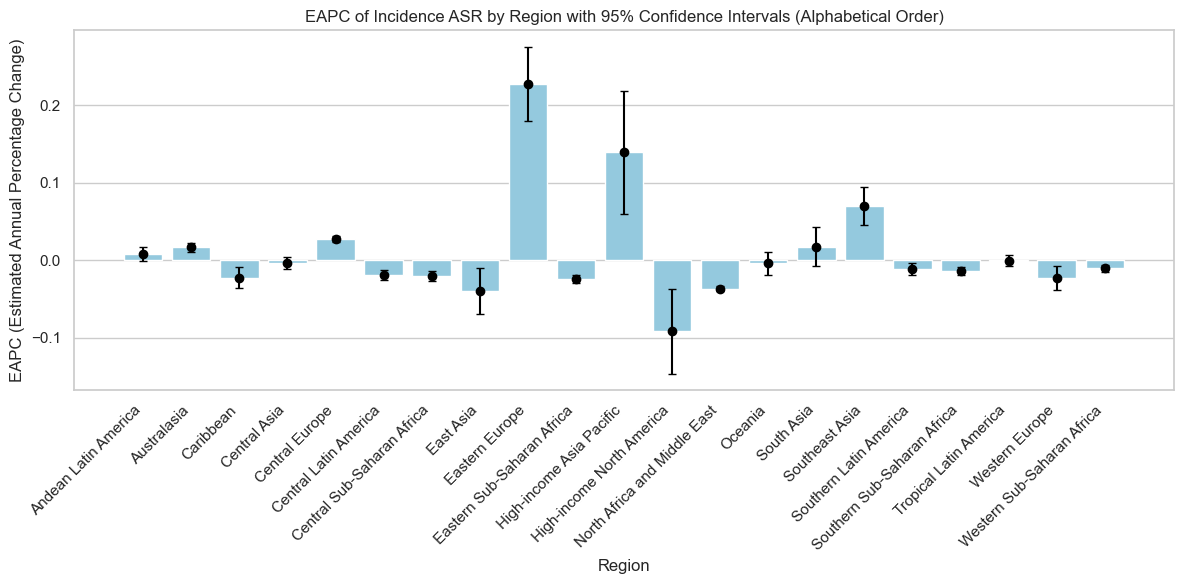

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('EAPC_analysis/EAPC_Incidence_ASR_REGIONAL.csv')
# Sort the data by Region in alphabetical order (as done in the previous step)
df_sorted_alpha = df.sort_values(by='Region', ascending=True)

# Create the plot
plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")

# Create a vertical bar plot for EAPC values, with Region on X and EAPC on Y
ax = sns.barplot(x='Region', y='EAPC', data=df_sorted_alpha, color='skyblue', errorbar=None)

# Add error bars
for index, row in df_sorted_alpha.iterrows():
    plt.errorbar(x=row['Region'], y=row['EAPC'], yerr=[[row['EAPC'] - row['CI_lower']], [row['CI_upper'] - row['EAPC']]],
                 fmt='o', color='black', capsize=3)

# Add labels and title
plt.xlabel('Region')
plt.ylabel('EAPC (Estimated Annual Percentage Change)')
plt.title('EAPC of Incidence ASR by Region with 95% Confidence Intervals (Alphabetical Order)')

# Rotate x-axis labels diagonally for better readability
plt.xticks(rotation=45, ha='right') # 'ha' (horizontal alignment) set to 'right' helps align the rotated labels better

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot
plt.savefig('eapc_plot_alpha_vertical_diagonal_labels.png')

how the fuck do i do this shit


In [ ]:
# \hspace{1em}Andean Latin America &
# \valrng{4.48}{3.9-5.2} & \valrng{12.23}{10.78-14.02} & \valrng{7.72}{6.79-8.91} & \valrng{12.26}{10.83-14.05} & \valrng{0.008}{-0.001 \text{ to } 0.017} &
# \valrng{3.7}{2.73-4.65} & \valrng{122.69}{91.36-153.44} & \valrng{7.53}{5.63-9.42} & \valrng{125.26}{93.77-155.89} & \valrng{0.074}{0.061 \text{ to } 0.087} \\

